## Perturbation of sequences
### Dataset: HEV ORF1 Sequences of Human only
### Number of sequences = 694
### Max Seq Length = 794
### Model: Transformer

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/..']

In [2]:
from models.nlp.transformer import transformer, transformer_model
from models.nlp import lstm, cnn1d
from datasets.protein_sequence_dataset import ProteinSequenceDataset
from utils import utils, nn_utils, visualization_utils
from models.nlp.embedding.padding import Padding
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO
from Bio.Seq import Seq
from Bio import motifs


In [3]:
input_file_path = "/home/grads/blessyantony/dev/git/zoonosis/input/data/hev/aligned/hev_orf1_alignment_ba.fasta_processed.csv"
output_dir = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/hev/20231017/perturbed_dataset_prediction/orf1-aligned/transformer-l_6-h_8-lr1e-4/processed"
model_path = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/hev/20231012/host_multi_e50/orf1/transformer-l_6-h_8-lr1e-4-orf1_itr0.pth"


hev_df = pd.read_csv(input_file_path)

label_groupings = {
                    "Human": [ "Human" ],
                    "Boar": [ "Boar" ],
                    "Others": [ "*" ]
                }

amino_acid_idx_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                  'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                  'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                  'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                  'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                  'J': 26, "-": 0}

idx_amino_acid_map = {v:k for k,v in amino_acid_idx_map.items()}
id_col = "id"
test_sequence_settings =  {
    "sequence_col": "sequence",
    "batch_size": 1,
    "max_sequence_length": 2481,
    "pad_sequence_val": 0,
    "truncate": True,
    "feature_type": "token"
}


label_settings = {
    "label_col": "host",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

model = {
    "max_seq_len": 2481,
    "loss": "CrossEntropyLoss",
    "with_convolution": False,
    "n_heads": 8,
    "depth": 6,
    "n_tokens": 27,
    "n_classes": 3,
    "n_epochs": 10,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024
}

def post_plot_config():
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 8

In [4]:
hev_df

,id,region,host,genotype,host-genotype,sequence
0,QJQ50412.1,ORF1,Avian,unknown,Avian-unknown,-MDVSQFAESKGVKTALEAAALAAANTALRNARVVTPYLTQQQTKN...
1,UNQ84074.1,ORF1,Avian,unknown,Avian-unknown,-MDVSQFAESKGVKTALEAAALAAANTALRNARVVTPYLTQQQTKN...
2,AAS45830.1,ORF1,Avian,unknown,Avian-unknown,-MDVSQFAESKGVKTALEAAALAAANTALRNARVVTPYLTQQQTKN...
3,YP_009001465.1,ORF1,Avian,unknown,Avian-unknown,-MDVSQFAESKGVKTALEAAALAAANTALRNARVVTPYLTQQQTKN...
4,UFQ90535.1,ORF1,Avian,unknown,Avian-unknown,-MDVSQFAESKGVKTALEAAALAAANTALRNARVVTPYLTQQQTKN...
...,...,...,...,...,...,...
949,AAA45732.1,ORF1,Unknown,HEV2,Unknown-HEV2,----------------------------------------------...
950,AAA45736.1,ORF1,Unknown,HEV1,Unknown-HEV1,----------------------------------------------...
951,AAS45831.1,ORF1,Avian,unknown,Avian-unknown,----------------------------------------------...
952,YP_009001467.1,ORF1,Avian,unknown,Avian-unknown,----------------------------------------------...


In [5]:
hev_human_df = hev_df[hev_df["host"] == "Human"]
hev_human_df

,id,region,host,genotype,host-genotype,sequence
14,BAD74175.1,ORF1,Human,HEV3,Human-HEV3,-MEAHQFIKAPGITTAIEQAALAAANSALANAVVVRPFLSRVQTEI...
15,BAD74178.1,ORF1,Human,HEV3,Human-HEV3,-MEAHQFIKAPGITTAIEQAALAAANSALANAVVVRPFLSRVQTEI...
17,BAD74181.1,ORF1,Human,HEV3,Human-HEV3,-MEAHQFIKAPGITTAIEQAALAAANSALANAVVVRPFLSRVQTEI...
18,BAD74172.1,ORF1,Human,HEV3,Human-HEV3,-MEAHQFIKAPGITTAIEQAALAAANSALANAVVVRPFLSRVQTEI...
19,BAG67055.1,ORF1,Human,HEV3,Human-HEV3,-MEAHQFIKAPGITTAIEQAALAAANSALANAVVVRPFLSRVQTEI...
...,...,...,...,...,...,...
914,QAU19544.1,ORF1,Human,unknown,Human-unknown,-METHQYVAATGVNTAREAQATAAAATAFANAQVVRPYLSHSQASL...
917,QEV82316.1,ORF1,Human,unknown,Human-unknown,-METHQYVAATGVNTAREAQATAAAATAFANAQVVRPYLSHSQASL...
919,QEV82319.1,ORF1,Human,unknown,Human-unknown,-METHQYVAATGVNTAREAQATAAAATAFANAQVVRPYLSHSQASL...
920,QEV82325.1,ORF1,Human,unknown,Human-unknown,-METHQYVAATGVNTAREAQATAAAATAFANAQVVRPYLSHSQASL...


In [6]:
def get_token_dataset_loader(df, sequence_settings, label_settings):
    label_col = label_settings["label_col"]
    
    seq_col = sequence_settings["sequence_col"]
    batch_size = sequence_settings["batch_size"]
    max_seq_len = sequence_settings["max_sequence_length"]
    pad_sequence_val = sequence_settings["pad_sequence_val"]
    truncate = sequence_settings["truncate"]
    
    df = df[[seq_col, label_col]]
    df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")

    dataset = ProteinSequenceDataset(df, seq_col, max_seq_len, truncate, label_col)
    return index_label_map, DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True,
                      collate_fn=Padding(max_seq_len, pad_sequence_val))


def get_dataset_loader_for_seq(genbank_id):
    id_df = hev_human_df[hev_human_df["id"] == genbank_id]
    index_label_map, dataset_loader =  get_token_dataset_loader(id_df, test_sequence_settings, label_settings)
    return id_df, index_label_map, dataset_loader

def get_aligned_seq(genbank_id):
    aligned_seq_row = hev_human_df[hev_human_df["id"] == genbank_id]
    aligned_seq = aligned_seq_row["seq"].values[0]
    aligned_token_count = aligned_seq_row["aligned_token_count"].values[0]
    return aligned_seq, aligned_token_count

### Load the model

In [7]:
tf_custom_model = transformer.get_transformer_model(model)
tf_custom_model.load_state_dict(torch.load(model_path))
tf_custom_model = tf_custom_model.to(nn_utils.get_device())
tf_custom_model.eval()
tf_custom_model.zero_grad()

Transformer(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): FeedForwardLayer(
          (W_1): Linear(in_features=512, out_features=1024, bias=True)
          (W_2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnectionLayer(
            (norm): NormalizationLayer()
          )
        )
      )
    )
    (norm): NormalizationLayer()
  )
  (linear): Linear(in_features=512, out_features=3, b

In [8]:
def validate(model, dataset_loader, index_label_map):
    with torch.no_grad():
        model.eval()

        results = []

        for _, data in enumerate(dataset_loader):
            # get input and labels; data is a list of [(inputs, labels)]
            inputs, labels = data

            output = model(inputs)

            # tensorboard + logs

            # to get probabilities of the output
            output = F.softmax(output, dim=-1)
            result_df = pd.DataFrame(output.cpu().numpy())
            result_df.rename(columns=index_label_map, inplace=True)
            result_df["y_true"] = labels.cpu().numpy()
            result_df["y_true"] = result_df["y_true"].map(index_label_map)
            
            results.append(result_df)
    
    return inputs, pd.concat(results, ignore_index=True)

In [9]:
def get_aligned_seq_pos_mapping(seq):
    aligned_seq_pos_map = {}
    token_count = 0
    for i, token in enumerate(seq):
        if token == "-":
            aligned_seq_pos_map[i] = 0
        else:
            token_count += 1
            aligned_seq_pos_map[i] = token_count
    return aligned_seq_pos_map

In [10]:
output_files = os.listdir(output_dir)
print(f"Number of perturbed output files = {len(output_files)}")

diff_dfs = []
for output_file in output_files:
    regex_result = re.search(r"tf\_hev\_orf1\_alignment\_ba\.fasta\_processed\.csv\_([A-Z0-9\.]+)\.csv", output_file)
    genbank_id = regex_result.group(1)
    print(output_file)
    print(genbank_id)
    genbank_id_df, index_label_map, dataset_loader = get_dataset_loader_for_seq(genbank_id)
    
    inputs, output_df = validate(tf_custom_model, dataset_loader, index_label_map)
    perturbed_output_df = pd.read_csv(os.path.join(output_dir, output_file))
    orig_seq = genbank_id_df["sequence"].values[0]
    aligned_seq_pos_map = get_aligned_seq_pos_mapping(orig_seq)
    orig_seq_human_pred = output_df["Human"].values[0]
    perturbed_output_df = perturbed_output_df[["Human", "id", "orig_token", "perturb_pos", "new_token"]]
    perturbed_output_df["seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: aligned_seq_pos_map[x])
    perturbed_output_df["pred_diff"] = perturbed_output_df["Human"] - orig_seq_human_pred
    pivot_df = perturbed_output_df.pivot(columns="seq_pos", index="new_token", values="pred_diff")
    diff_dfs.append(pivot_df)
    break

Number of perturbed output files = 349
tf_hev_orf1_alignment_ba.fasta_processed.csv_BBF24643.1.csv
BBF24643.1
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [11]:
perturbed_output_df

,Human,id,orig_token,perturb_pos,new_token,seq_pos,pred_diff
0,0.463817,BBF24643.1,V,2431,S,1659,0.000065
1,0.463765,BBF24643.1,E,1992,A,1257,0.000013
2,0.463729,BBF24643.1,P,831,F,716,-0.000023
3,0.463766,BBF24643.1,R,2312,W,1551,0.000014
4,0.463740,BBF24643.1,T,1451,P,842,-0.000012
...,...,...,...,...,...,...,...
42571,0.463735,BBF24643.1,A,1753,B,1020,-0.000017
42572,0.463791,BBF24643.1,F,1164,G,756,0.000039
42573,0.463777,BBF24643.1,D,1161,P,753,0.000025
42574,0.463559,BBF24643.1,D,644,B,578,-0.000193


In [12]:
n_bins = 12
n = perturbed_output_df.shape[0]
freq, bins = np.histogram(perturbed_output_df["pred_diff"], bins=n_bins)
hist_map = []
for i in range(n_bins):
    hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})

    
hist_df = pd.DataFrame(hist_map)
hist_df.head(20)

,start,end,count,percentage
0,-0.194640,-0.158293,25,0.058719
1,-0.158293,-0.121947,3,0.007046
2,-0.121947,-0.085601,1,0.002349
3,-0.085601,-0.049255,3,0.007046
4,-0.049255,-0.012909,32,0.075160
5,-0.012909,0.023438,42487,99.790962
6,0.023438,0.059784,0,0.000000
7,0.059784,0.096130,0,0.000000
8,0.096130,0.132476,0,0.000000
9,0.132476,0.168822,0,0.000000


In [13]:
df = perturbed_output_df.pivot(columns="seq_pos", index="new_token", values="pred_diff")
df

seq_pos,1,2,3,4,5,6,7,8,9,10,...,1694,1695,1696,1697,1698,1699,1700,1701,1702,1703
new_token,,,,,,,,,,,,,,,,,,,,,
A,2.851848e-05,1.641848e-05,NaN,0.000006,1.471848e-05,2.282848e-05,9.178476e-06,1.021848e-05,NaN,7.748476e-06,...,0.000003,0.000005,0.000039,-0.000016,1.486848e-05,0.000039,1.889848e-05,0.000035,3.632848e-05,1.692848e-05
B,7.658476e-06,-8.401524e-06,-0.000026,-0.000015,-1.461524e-06,9.178476e-06,-4.401524e-06,-5.121524e-06,-0.000017,-1.046152e-05,...,-0.000030,-0.000024,0.000014,-0.000037,-5.001524e-06,0.000017,-8.601524e-06,0.000003,5.398476e-06,-9.901524e-06
C,1.699848e-05,5.598476e-06,-0.000010,-0.000001,1.006848e-05,1.919848e-05,3.818476e-06,1.668476e-06,-0.000012,-5.271524e-06,...,-0.000009,-0.000008,0.000026,-0.000028,3.818476e-06,0.000028,6.898476e-06,0.000022,2.282848e-05,4.378476e-06
D,9.284760e-07,-1.767152e-05,-0.000036,-0.000025,-1.085152e-05,5.684760e-07,-1.198152e-05,-1.090152e-05,-0.000021,-1.374152e-05,...,-0.000047,-0.000039,NaN,-0.000052,-2.214152e-05,-0.000005,-3.704152e-05,-0.000028,-2.387152e-05,-3.517152e-05
E,1.322848e-05,NaN,-0.000017,-0.000009,8.384760e-07,1.036848e-05,-2.141524e-06,-9.515240e-07,-0.000012,-4.651524e-06,...,-0.000014,-0.000011,0.000023,-0.000031,1.184760e-07,0.000024,2.198476e-06,0.000017,1.862848e-05,NaN
F,2.268476e-06,-1.470152e-05,-0.000031,-0.000022,-9.831524e-06,NaN,-1.280152e-05,-1.138152e-05,-0.000021,-1.320152e-05,...,-0.000029,-0.000026,0.000010,-0.000041,-7.121524e-06,0.000017,-5.201524e-06,0.000009,9.798476e-06,-8.401524e-06
G,1.539848e-05,2.768476e-06,-0.000013,-0.000006,4.378476e-06,1.329848e-05,-5.015240e-07,-3.015240e-07,-0.000012,-4.601524e-06,...,-0.000009,-0.000007,0.000027,-0.000028,3.128476e-06,0.000028,7.178476e-06,0.000023,2.446848e-05,5.248476e-06
H,2.579848e-05,1.322848e-05,-0.000005,NaN,9.238476e-06,1.924848e-05,8.228476e-06,1.119848e-05,0.000001,7.658476e-06,...,-0.000004,-0.000001,0.000034,-0.000020,1.173848e-05,0.000037,1.719848e-05,0.000033,3.322848e-05,1.284848e-05
I,1.427848e-05,5.847603e-08,-0.000017,-0.000008,3.498476e-06,1.355848e-05,NaN,-3.615240e-07,-0.000012,-5.121524e-06,...,-0.000016,-0.000012,0.000023,-0.000031,NaN,0.000023,-1.015240e-07,0.000014,1.543848e-05,-2.231524e-06


In [35]:
df[539]

new_token
A   -0.194558
B   -0.194581
C   -0.194574
D   -0.194582
E   -0.194578
F   -0.194567
G   -0.194578
H         NaN
I   -0.194576
J   -0.194613
K   -0.194580
L   -0.194563
M   -0.194584
N   -0.194577
O   -0.194581
P   -0.194570
Q   -0.194574
R   -0.194572
S   -0.194640
T   -0.194570
U   -0.194584
V   -0.194574
W   -0.194575
X   -0.194576
Y   -0.194581
Z   -0.194583
Name: 539, dtype: float64

In [36]:
df[514]

new_token
A    0.241387
B    0.241379
C    0.241385
D    0.241372
E    0.241398
F    0.241375
G    0.241388
H         NaN
I    0.241367
J    0.241359
K    0.241399
L    0.241375
M    0.241353
N    0.241354
O    0.241394
P    0.241407
Q    0.241365
R    0.241329
S    0.241515
T    0.241405
U    0.241373
V    0.241434
W    0.241394
X    0.241403
Y    0.241394
Z    0.241389
Name: 514, dtype: float64

<Figure size 640x480 with 0 Axes>

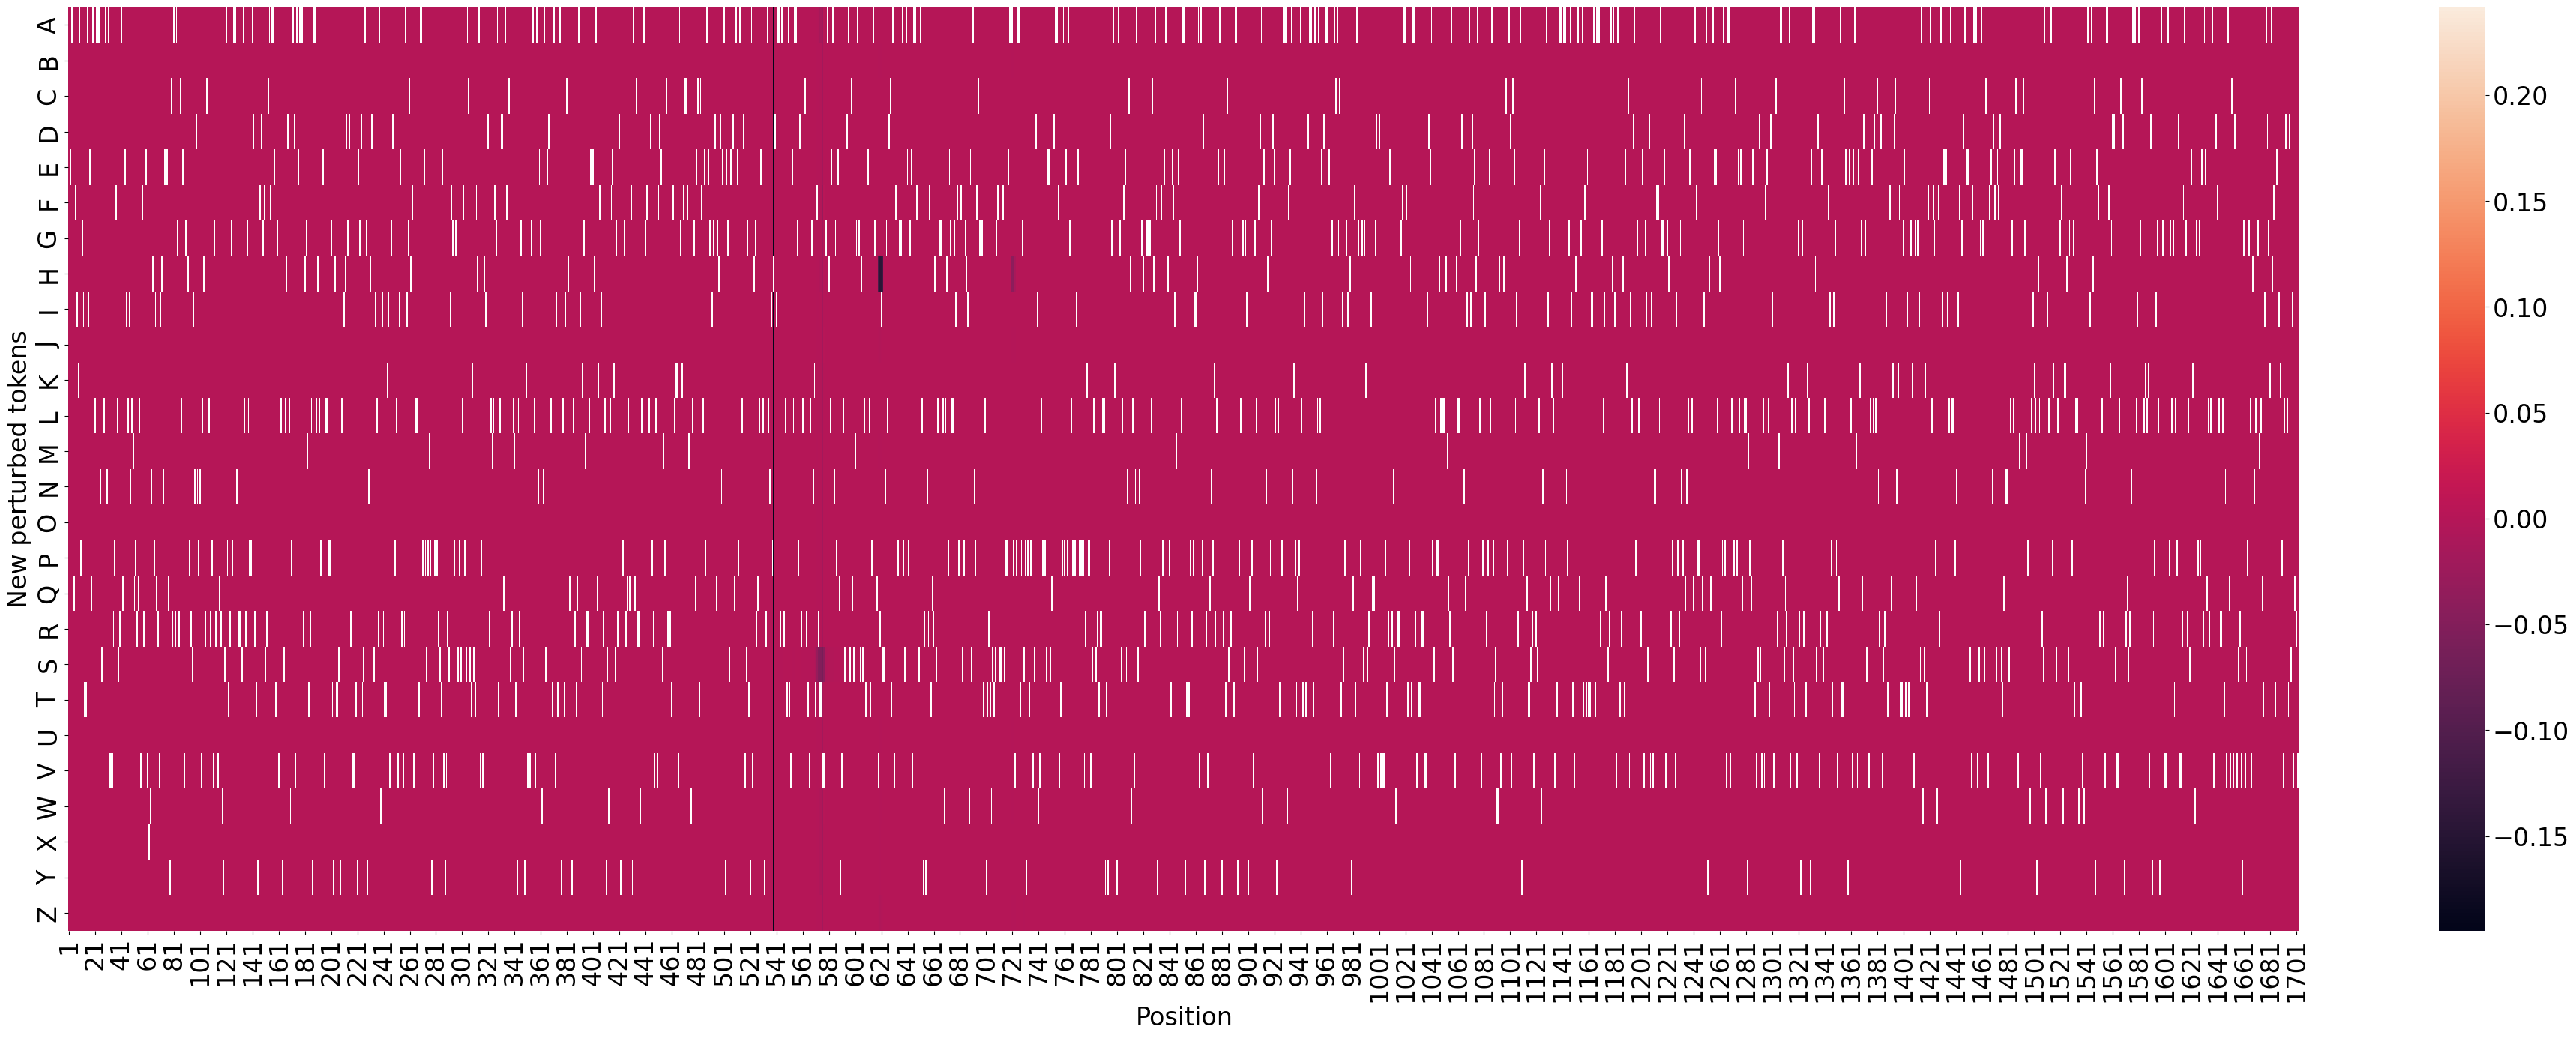

In [14]:
# visualization_utils.pre_plot_config(figsize=(40, 20))
plt.clf()
plt.figure(figsize=(48, 16))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
ax = sns.heatmap(df)
# plt.rcParams['figure.autolayout'] = True
plt.xlabel('Position', fontsize=24)
plt.ylabel('New perturbed tokens', fontsize=24)
output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "output/visualization/uniref90/20231022/host_multi_val_test_e50/hev_orf1_randomseq_perturbation_heatmap.pdf")
plt.savefig(output_filepath)
plt.show()

In [15]:
df.mean(axis=0)

seq_pos
1       1.275578e-05
2      -1.209124e-06
3      -1.897872e-05
4      -1.090392e-05
5       5.132760e-07
            ...     
1699    2.414168e-05
1700    9.316760e-07
1701    1.515528e-05
1702    1.648648e-05
1703   -2.600324e-06
Length: 1703, dtype: float64

<Figure size 640x480 with 0 Axes>

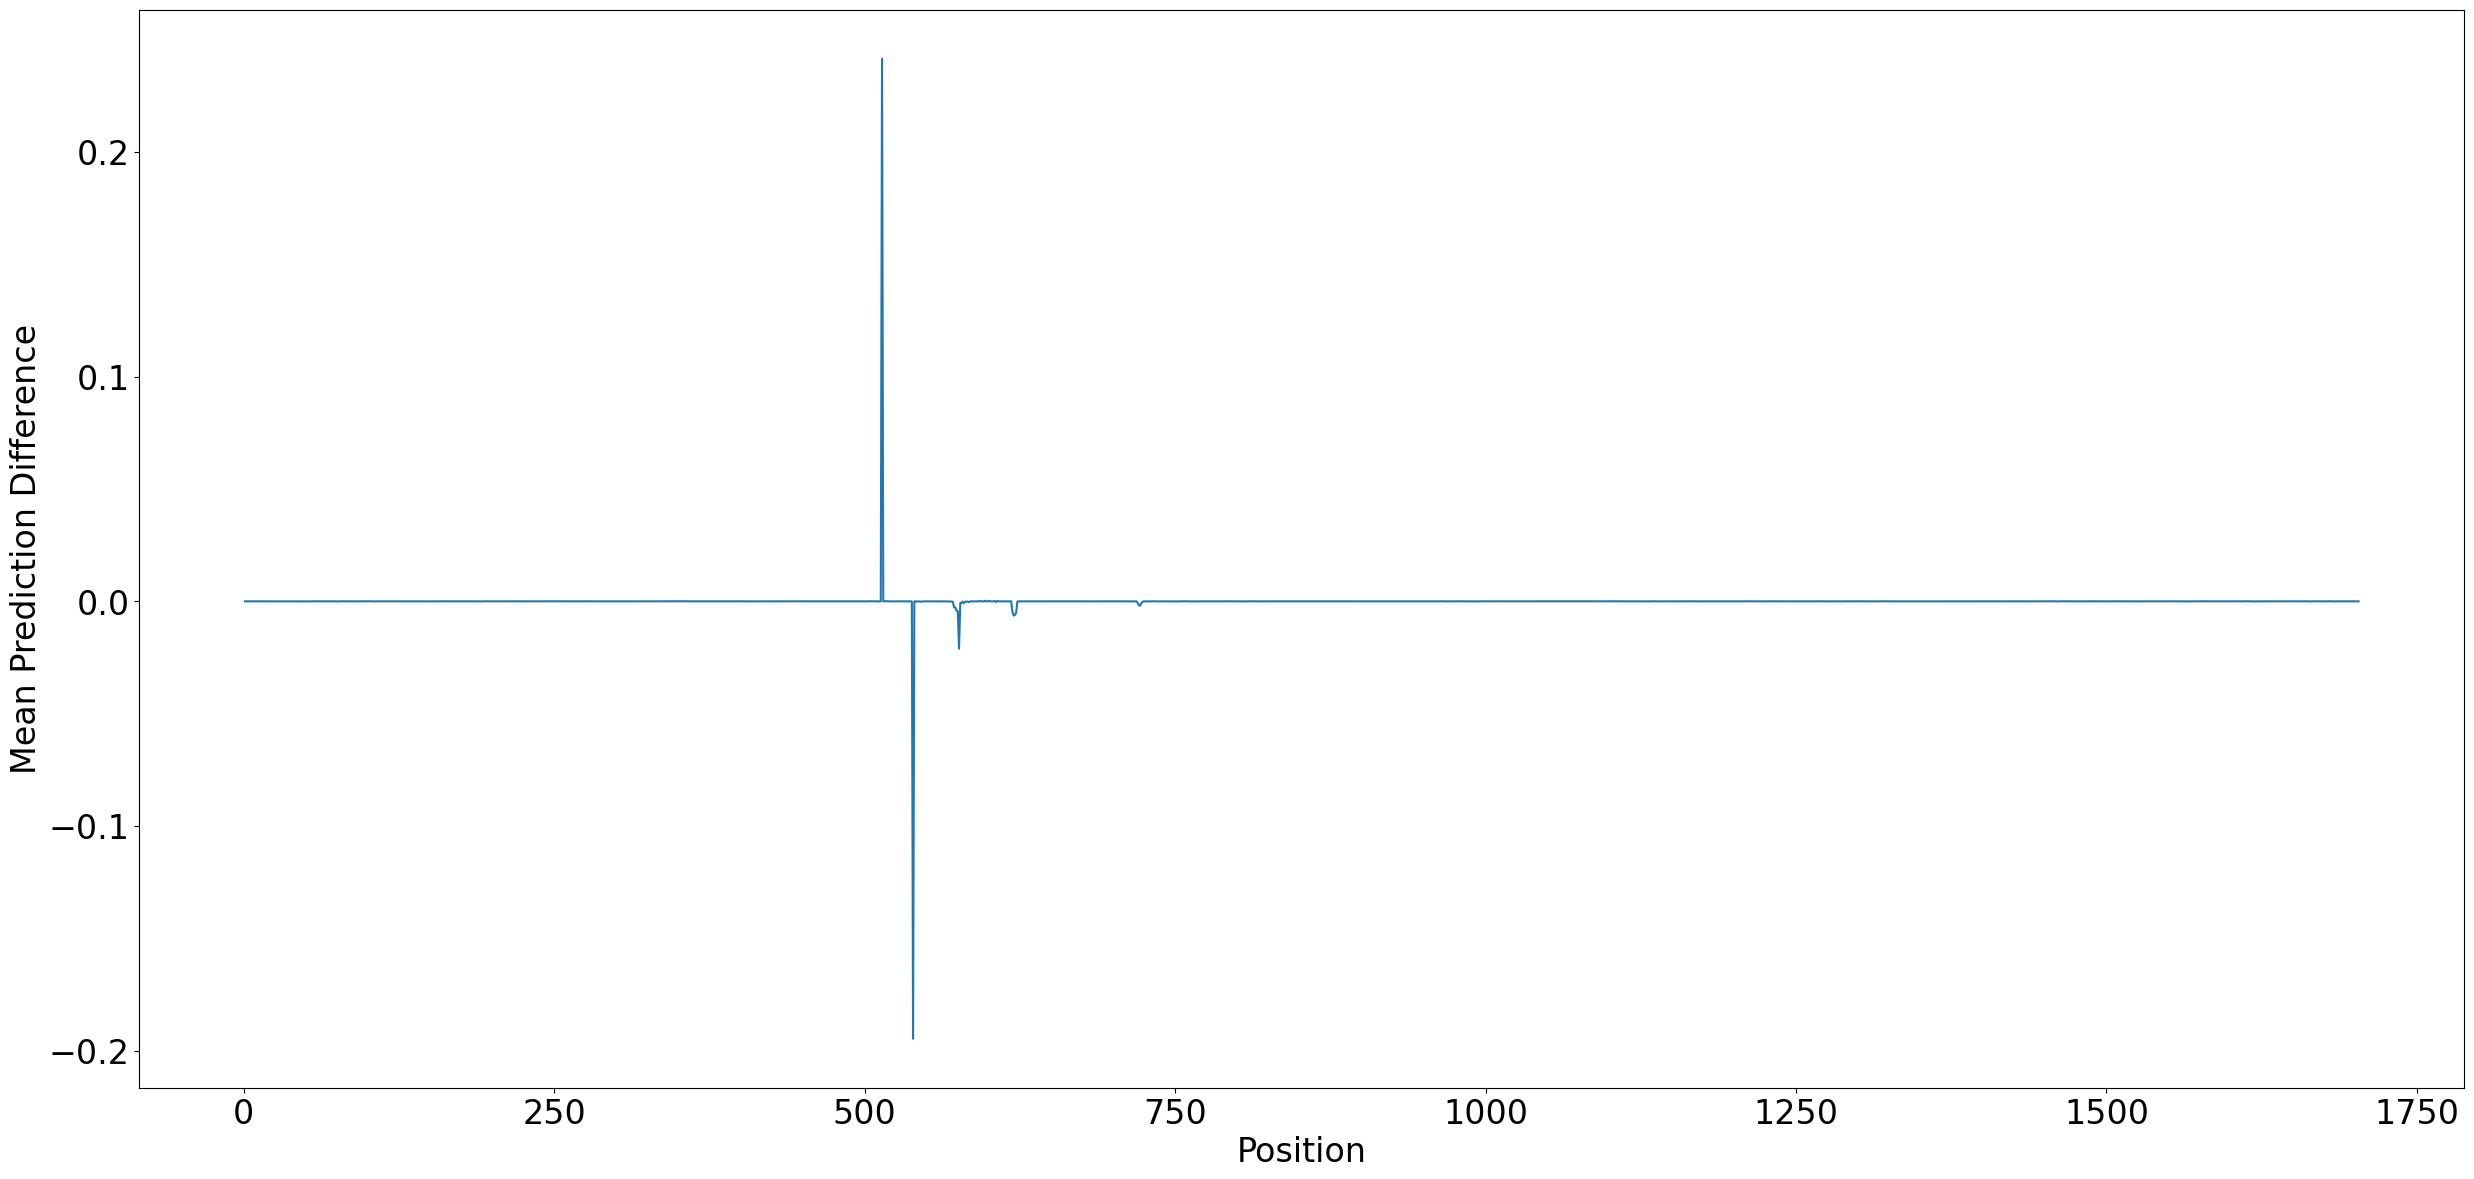

In [32]:
plt.clf()
plt.figure(figsize=(30, 14))
ax = sns.lineplot(df.mean(axis=0))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.xlabel('Position', fontsize=24)
plt.ylabel('Mean Prediction Difference', fontsize=24)
output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "output/visualization/uniref90/20231022/host_multi_val_test_e50/hev_orf1_randomseq_perturbation_mean.pdf")
plt.savefig(output_filepath)

plt.show()

In [29]:
df.mean(axis=0).idxmax()

514

In [30]:
df.mean(axis=0).idxmin()

539

### Identify important position across all sequences

In [18]:
mean_diff_dfs = [x_df.mean(axis=0) for x_df in diff_dfs]

In [19]:
mean_diff_df = pd.DataFrame(mean_diff_dfs)
mean_diff_df

seq_pos,1,2,3,4,5,6,7,8,9,10,...,1694,1695,1696,1697,1698,1699,1700,1701,1702,1703
0,0.000013,-0.000001,-0.000019,-0.000011,5.132760e-07,0.00001,-0.000003,-0.000002,-0.000014,-0.000006,...,-0.000017,-0.000014,0.000022,-0.000033,-4.159240e-07,0.000024,9.316760e-07,0.000015,0.000016,-0.000003


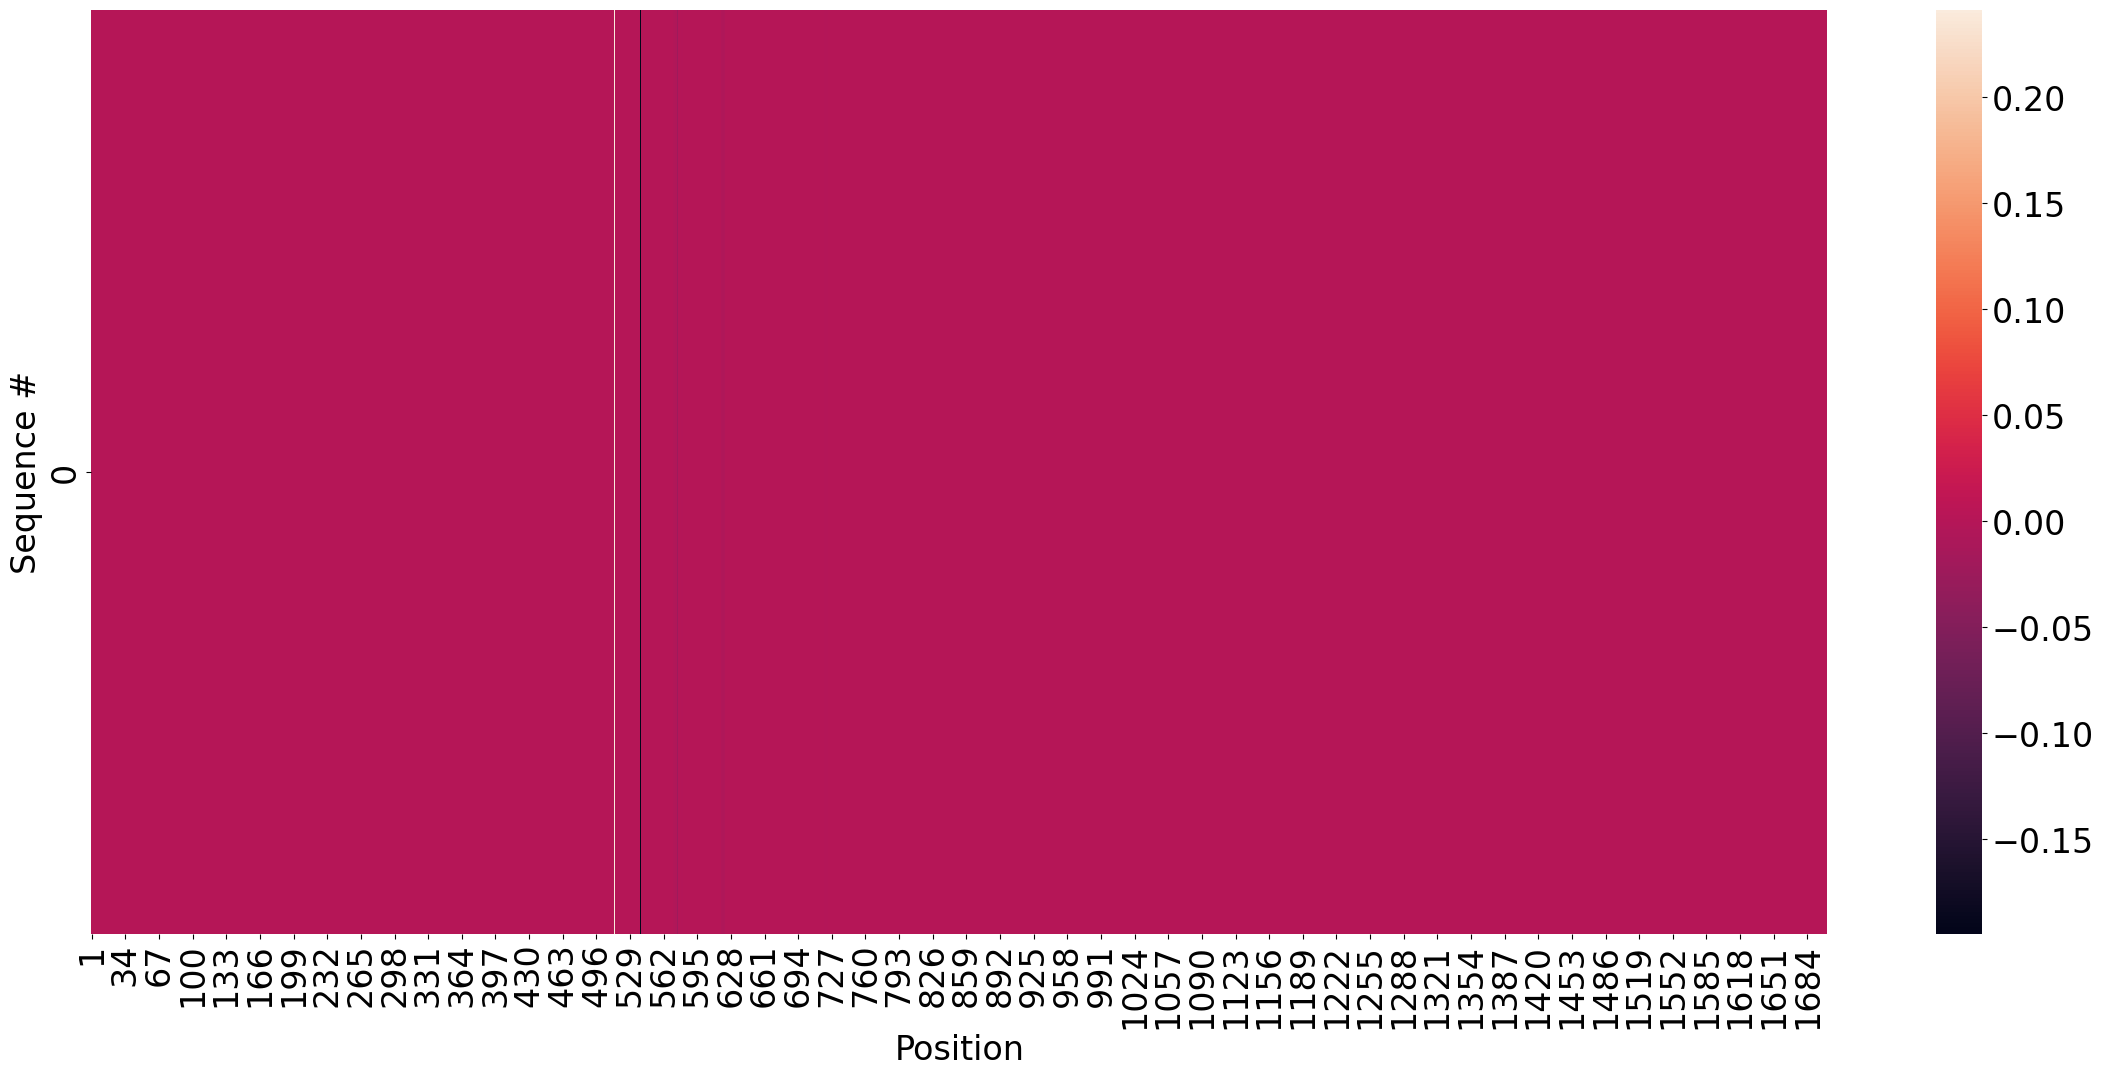

In [20]:
plt.figure(figsize=(28,12))
sns.heatmap(mean_diff_df)
plt.xlabel('Position', fontsize=24)
plt.ylabel('Sequence #', fontsize=24)
plt.show()

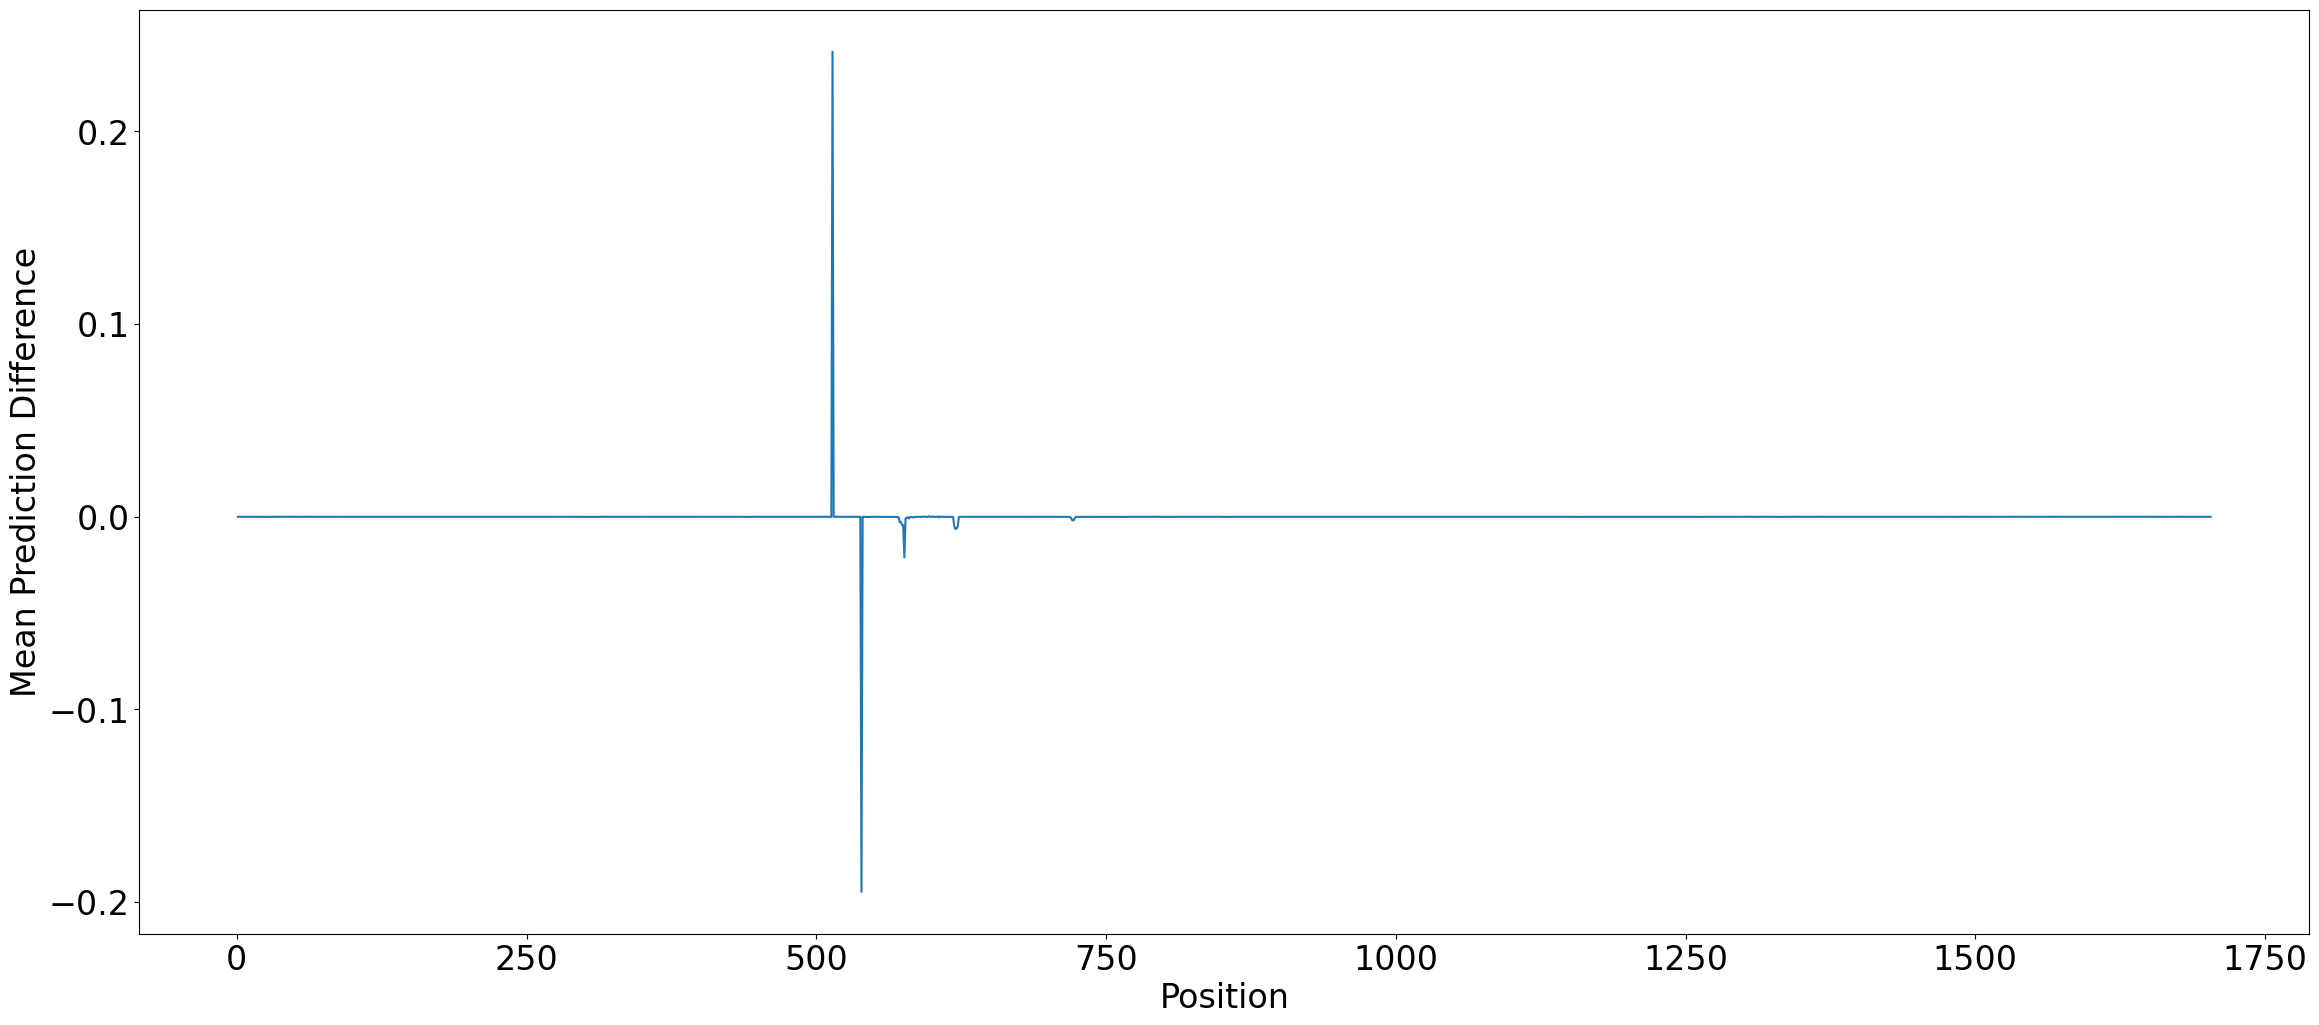

In [21]:
plt.figure(figsize=(28,12))
sns.lineplot(mean_diff_df.mean(axis=0))
plt.xlabel('Position', fontsize=24)
plt.ylabel('Mean Prediction Difference', fontsize=24)
plt.show()

In [22]:
mean_diff_df.mean(axis=0).idxmin()

539

In [23]:
# retain only negative values i.e. probability of Human host decreases
mean_diff_df[mean_diff_df >= 0 ] = None

# drop all columns (positions) with atleast 10% non-NaN values i.e. this position does not decrease the probability for 90% or more of the sequences
# argument 'thresh': Require that many non-NA values.
mean_diff_df.dropna(axis=1, how="all", thresh=0.9*mean_diff_df.shape[0], inplace=True)

In [24]:
mean_diff_df.shape

(1, 1166)

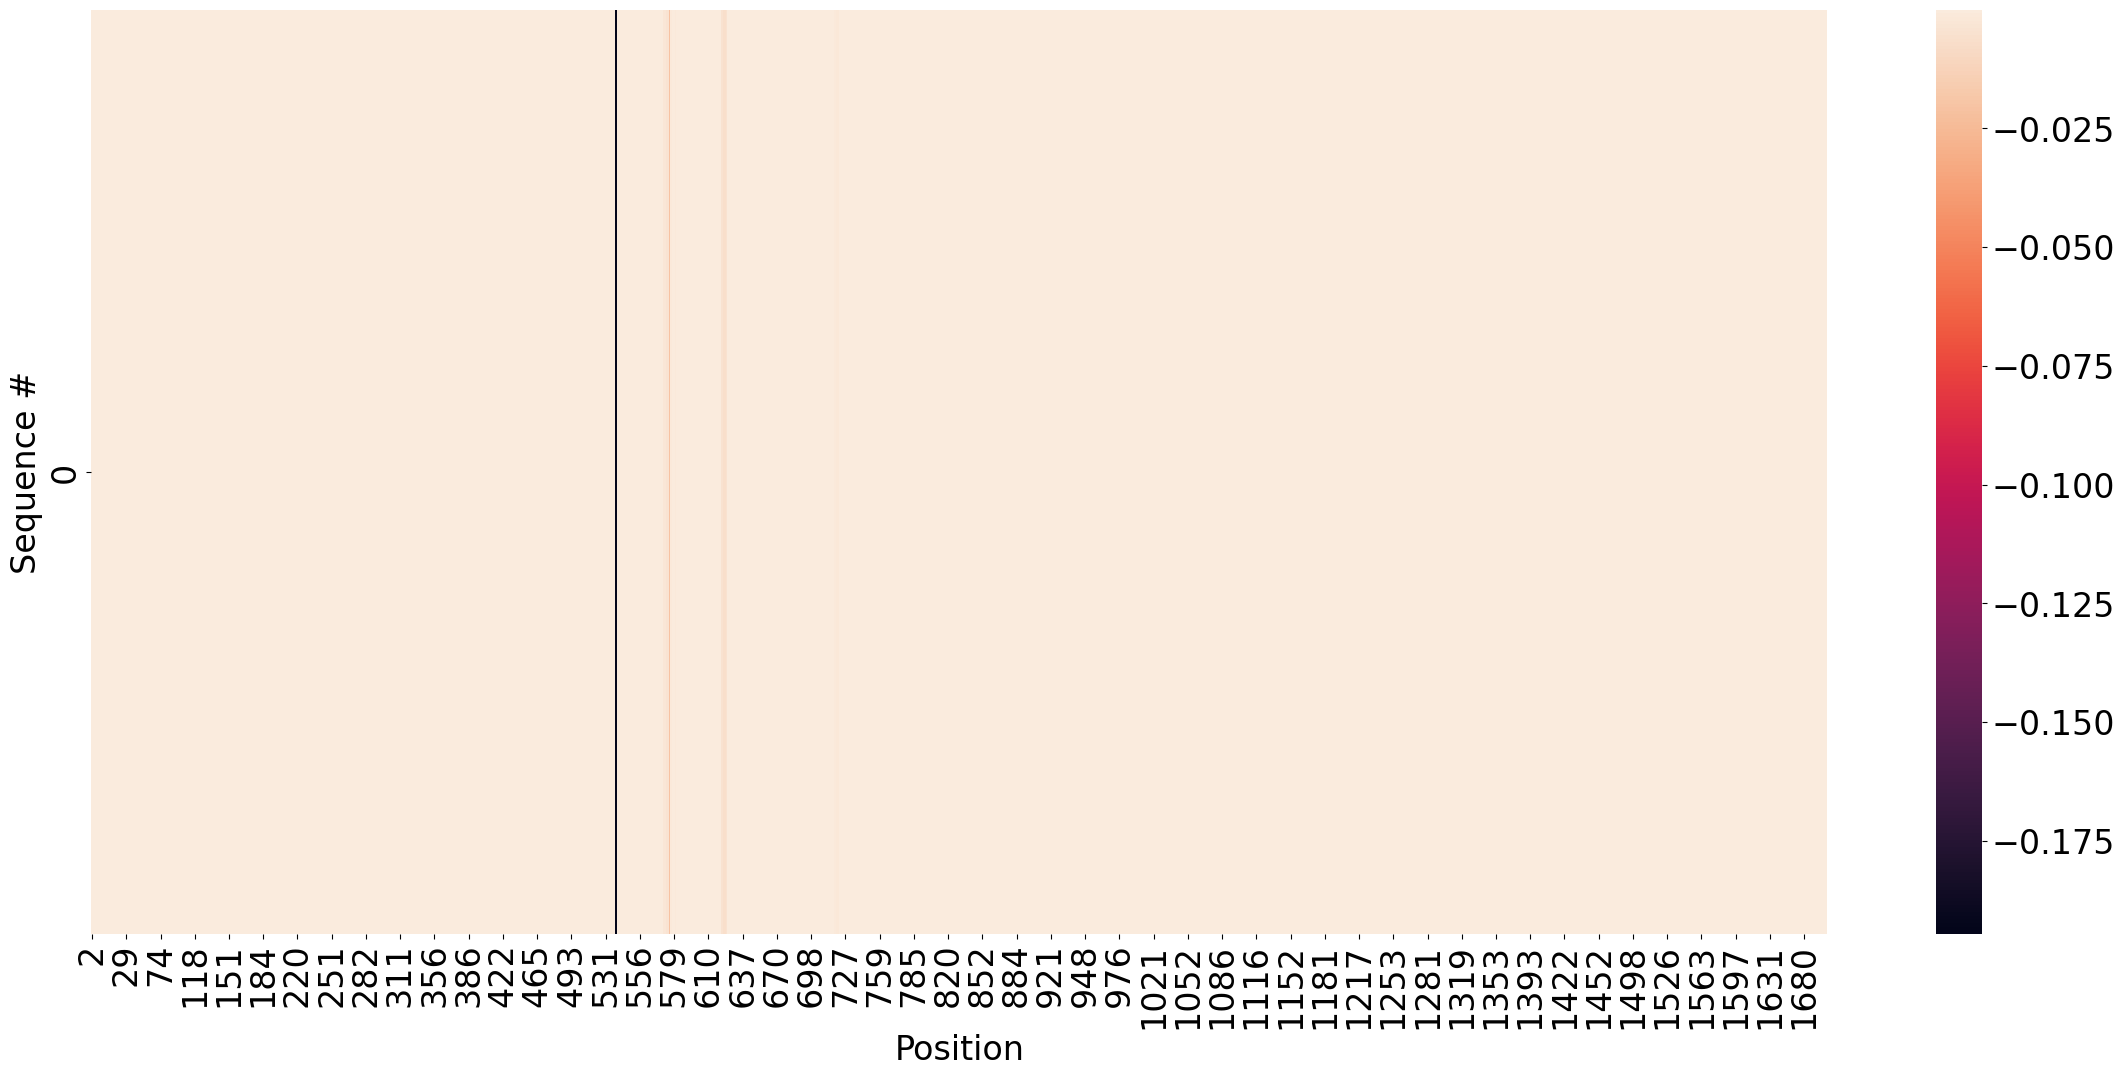

In [25]:
plt.figure(figsize=(28,12))
sns.heatmap(mean_diff_df)
plt.xlabel('Position', fontsize=24)
plt.ylabel('Sequence #', fontsize=24)
plt.show()

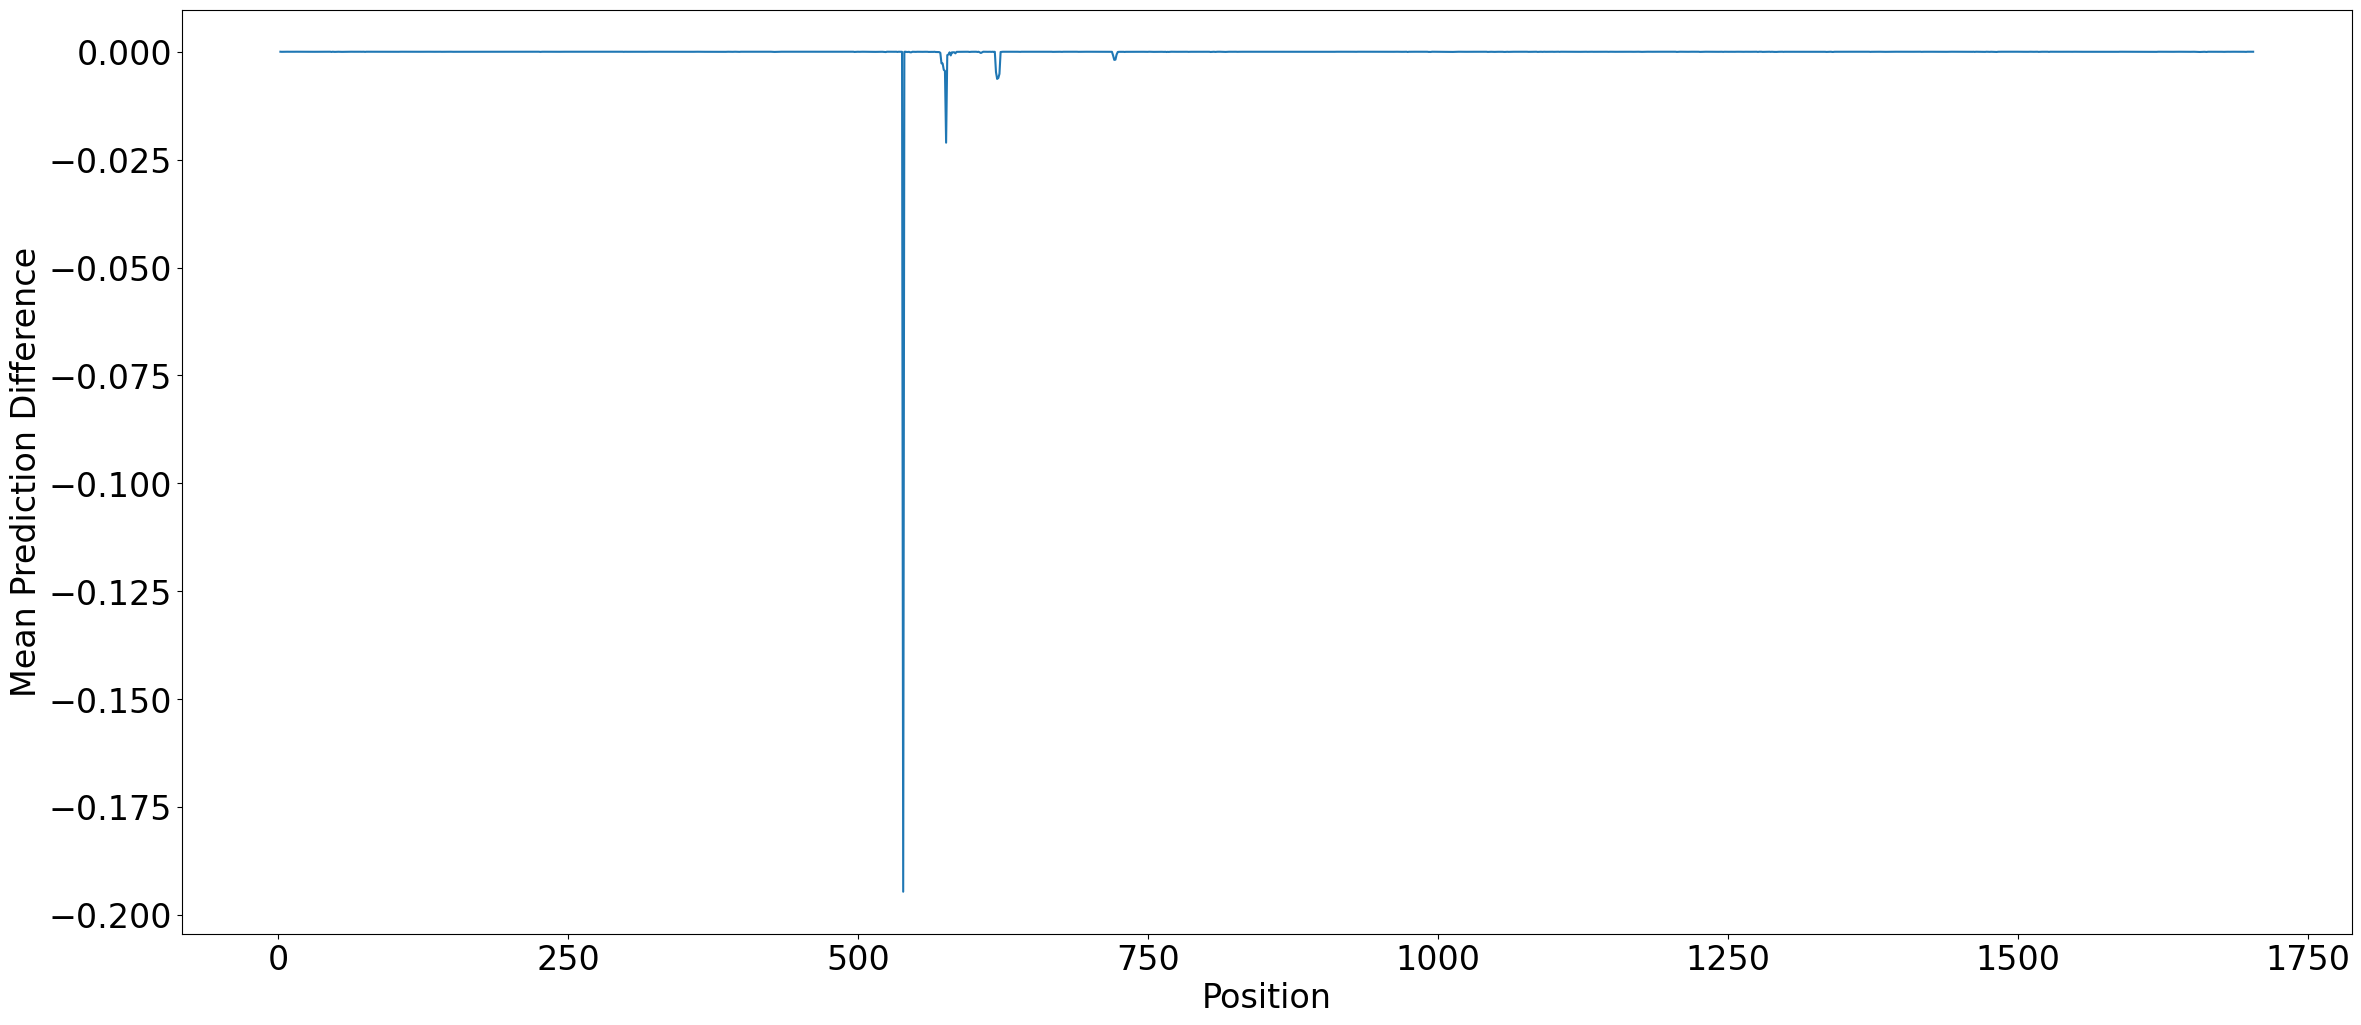

In [33]:
plt.figure(figsize=(28,12))
sns.lineplot(mean_diff_df.mean(axis=0))
plt.xlabel('Position', fontsize=24)
plt.ylabel('Mean Prediction Difference', fontsize=24)
output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "output/visualization/uniref90/20231022/host_multi_val_test_e50/hev_orf1_all_perturbation_mean.pdf")
plt.savefig(output_filepath)
plt.show()

In [34]:
mean_diff_df.mean(axis=0).nsmallest(10)

seq_pos
539   -0.194580
576   -0.021072
620   -0.006294
621   -0.006098
622   -0.005131
619   -0.004722
575   -0.004437
574   -0.004204
573   -0.002729
572   -0.002678
dtype: float64